In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from configs import get_config
import matplotlib.pyplot as plt

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [128]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [84]:
labels_pd.shape, counts_pd.shape

((700, 2), (700, 766))

In [67]:
labels = labels_pd['index'].to_numpy().astype(str)
labels[[0,1,2]]

array(['AAAGCCTGGCTAAC-1', 'AAATTCGATGCACA-1', 'AACACGTGGTCTTT-1'],
      dtype='<U16')

In [16]:
id2cell = {i:label for i, label in enumerate(labels_pd['bulk_labels'].unique())}
cell2id = {label:i for i, label in id2cell.items()}

({'CD14+ Monocyte': 0,
  'Dendritic': 1,
  'CD56+ NK': 2,
  'CD4+/CD25 T Reg': 3,
  'CD19+ B': 4,
  'CD8+ Cytotoxic T': 5,
  'CD4+/CD45RO+ Memory': 6,
  'CD8+/CD45RA+ Naive Cytotoxic': 7,
  'CD4+/CD45RA+/CD25- Naive T': 8,
  'CD34+': 9},
 {0: 'CD14+ Monocyte',
  1: 'Dendritic',
  2: 'CD56+ NK',
  3: 'CD4+/CD25 T Reg',
  4: 'CD19+ B',
  5: 'CD8+ Cytotoxic T',
  6: 'CD4+/CD45RO+ Memory',
  7: 'CD8+/CD45RA+ Naive Cytotoxic',
  8: 'CD4+/CD45RA+/CD25- Naive T',
  9: 'CD34+'})

In [2]:
labels = ['CD14+ Monocyte','Dendritic','CD56+ NK','CD4+/CD25 T Reg','CD19+ B','CD8+ Cytotoxic T','CD4+/CD45RO+ Memory','CD8+/CD45RA+ Naive Cytotoxic','CD4+/CD45RA+/CD25- Naive T','CD34+']
id2cell = {i:label for i, label in enumerate(labels)}
cell2id = {label:i for i, label in id2cell.items()}
id2cell, cell2id

({0: 'CD14+ Monocyte',
  1: 'Dendritic',
  2: 'CD56+ NK',
  3: 'CD4+/CD25 T Reg',
  4: 'CD19+ B',
  5: 'CD8+ Cytotoxic T',
  6: 'CD4+/CD45RO+ Memory',
  7: 'CD8+/CD45RA+ Naive Cytotoxic',
  8: 'CD4+/CD45RA+/CD25- Naive T',
  9: 'CD34+'},
 {'CD14+ Monocyte': 0,
  'Dendritic': 1,
  'CD56+ NK': 2,
  'CD4+/CD25 T Reg': 3,
  'CD19+ B': 4,
  'CD8+ Cytotoxic T': 5,
  'CD4+/CD45RO+ Memory': 6,
  'CD8+/CD45RA+ Naive Cytotoxic': 7,
  'CD4+/CD45RA+/CD25- Naive T': 8,
  'CD34+': 9})

In [124]:
labels_pd['index'].to_numpy().astype(str)[:20]

array(['AAAGCCTGGCTAAC-1', 'AAATTCGATGCACA-1', 'AACACGTGGTCTTT-1',
       'AAGTGCACGTGCTA-1', 'ACACGAACGGAGTG-1', 'ACAGTTCTTAGCCA-1',
       'ACATTCTGACTACG-1', 'ACCCTCGAGTGAGG-1', 'ACTGGCCTTTTCGT-1',
       'ACTTGGGAACCAGT-1', 'AGAAAGTGTGAACC-1', 'AGATATTGACCACA-1',
       'AGTAAGGATTTACC-1', 'AGTTAAACAAACAG-1', 'ATAACAACCTCTAT-1',
       'ATGGACACAAGTGA-1', 'ATGGACACTCGTTT-1', 'ATGGGTACCTGGTA-1',
       'ATGTAAACTTTCGT-1', 'ATTAACGATACGAC-1'], dtype='<U16')

In [153]:
numpy_counts = counts_pd.iloc[:,1:].to_numpy().astype(np.float32)
torch.from_numpy(numpy_counts).size()

torch.Size([700, 765])

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [3]:
"""
I might want to separate out the labels/indicies from the counts into two separate datasets, stacking them at the end using torch.utils.data.StackDataset
based on if it is training or not. I don't know if returning the labels and 
"""

class CellDataset(Dataset):
    def __init__(self, counts_csv_file:str, labels_csv_file:str, mode='train', test_size=0.2) -> tuple[torch.tensor, torch.tensor, np.ndarray]:
        assert mode in ['train', 'test'], f'mode needs to be either train or test, but it\'s {mode}'

        self.labels = ['CD14+ Monocyte','Dendritic','CD56+ NK','CD4+/CD25 T Reg','CD19+ B','CD8+ Cytotoxic T','CD4+/CD45RO+ Memory','CD8+/CD45RA+ Naive Cytotoxic','CD4+/CD45RA+/CD25- Naive T','CD34+']
        self.id2cell = {i:label for i, label in enumerate(self.labels)}
        self.cell2id = {label:i for i, label in self.id2cell.items()}
        
        counts_pd = pd.read_csv(counts_csv_file)
        numpy_counts = counts_pd.iloc[:,1:].to_numpy().astype(np.float32) # iloc[:, 1:] gets rid of the index column, leaving only normalized log count data

        labels_pd = pd.read_csv(labels_csv_file)
        id_labels = labels_pd['bulk_labels'].map(self.cell2id).to_numpy().astype(np.uint8)

        partition = int(len(labels_pd) * (1 - test_size))
    
        if mode == 'train':
            self.counts = torch.from_numpy(numpy_counts[:partition, :])
            self.labels = torch.from_numpy(id_labels[:partition])
            self.indicies = labels_pd['index'].to_numpy().astype(str)[:partition]
        else:
            self.counts = torch.from_numpy(numpy_counts[partition:, :])
            self.labels = torch.from_numpy(id_labels[partition:])
            self.indicies = labels_pd['index'].to_numpy().astype(str)[partition:]
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        log_counts = self.counts[idx]
        label = self.labels[idx]
        index = self.indicies[idx]
        return log_counts, label, index

    # def __getitems__(self, idxs):
    #     counts = self.counts[idxs]
    #     labels = self.labels[idxs]
    #     indicies = self.indicies[idxs]
    #     return counts, labels, indicies

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [4]:
MODEL_CONFIG = get_config("autoencoder_model.config")

In [6]:
input_size, num_hidden_layers, output_size = 765, 2, 16
jump = int(np.abs(np.ceil((input_size - output_size)/(num_hidden_layers))))
print(f"Jump: {np.abs((input_size - output_size) / (num_hidden_layers))}")

Jump: 374.5


In [68]:
size = input_size
layer_sizes = [input_size]
for _ in range(num_hidden_layers - 1):
    if input_size > output_size:
        size -= jump
        layer_sizes.append(size)
    elif input_size < output_size:
        size += jump
        layer_sizes.append(size)
    else:
        layer_sizes = [output_size for _ in range(num_hidden_layers - 1)]

# layer_output_sizes.append(output_size)
layer_sizes

[765, 390]

In [69]:
layer_sizes[-1]

390

In [80]:
find_hidden_dims(input_size, num_hidden_layers, output_size)

[765, 390]

In [81]:
[layer_sizes[i: i + 2] for i in range(len(layer_sizes) - 2 + 1)]

[[765, 390]]

In [5]:
def find_hidden_dims(in_size, num_layers, out_size):
    jump = int(np.abs(np.ceil((in_size - out_size) / num_layers)))
    size = in_size
    layer_sizes = [in_size]
    if in_size > out_size:
        for _ in range(num_layers - 1):
            size -= jump
            layer_sizes.append(size)
    elif in_size < out_size:
        for _ in range(num_layers - 1):
            size += jump
            layer_sizes.append(size)
    else:
        layer_sizes = [out_size for _ in range(num_layers - 1)]
 
    return layer_sizes

In [6]:
class NodeLayer(nn.Sequential):
    def __init__(self, input_size, output_size):
        super(NodeLayer, self).__init__(
            nn.Linear(input_size, output_size),
            nn.ReLU()
        )
        
class MLP(nn.Module):
    def __init__(self, input_size, num_hidden_layers, output_size):
        super(MLP, self).__init__()

        hidden_dims = find_hidden_dims(input_size, num_hidden_layers, output_size)
        
        self.hidden_layers = nn.Sequential(*[NodeLayer(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims) - 2 + 1)])
        self.out_layer = nn.Linear(hidden_dims[-1], output_size)

    def forward(self, x):
        x = self.hidden_layers(x)
        return self.out_layer(x)
        
class PBMCAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(PBMCAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [7]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange

In [101]:
def plot_history(history: dict[list,list]):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

In [9]:
def train(model, train_data:Dataset, test_data:Dataset, epochs, regularization:bool = False):
    # torch.cuda.empty_cache()
    model = model.to(DEVICE)

    train_loader = DataLoader(train_data, batch_size=MODEL_CONFIG['hyperparameters']['BATCH_SIZE'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=MODEL_CONFIG['hyperparameters']['BATCH_SIZE'], shuffle=True)

    best_val_loss = float('inf')
    best_model = None
    history = {
        'train_loss': [],
        'val_loss': [],
    }

    
    mse = nn.MSELoss()
    if regularization == True:
        l1 = nn.L1Loss()
        beta = MODEL_CONFIG['hyperparameters']['REGULARIZATION_WEIGHT']
    optimizer = torch.optim.AdamW(model.parameters(), lr=MODEL_CONFIG['hyperparameters']['LR'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=MODEL_CONFIG['hyperparameters']['LR_REDUCE_RATE'], 
                                                           patience=MODEL_CONFIG['hyperparameters']['PATIENCE'])

    epochs_pbar = trange(epochs, desc='Epochs')
    for epoch in epochs_pbar:
        # Training
        model.train()
        epoch_train_loss = 0.0
        for counts, _, _ in train_loader:
            counts = counts.to(DEVICE)

            logits = model(counts)
            if regularization == True:
                loss = mse(logits, counts) + beta * l1(logits, counts)
            else:
                loss = mse(logits, counts)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * counts.size(0)

        epoch_train_loss /= len(train_data)

        # Testing
        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for counts, _, _ in test_loader:
                counts = counts.to(DEVICE)

                logits = model(counts)
                if regularization == True:
                    loss = mse(logits, counts) + beta * l1(logits, counts)
                else:
                    loss = mse(logits, counts)

                epoch_val_loss += loss.item() * counts.size(0)

        epoch_val_loss /= len(test_data)
        
        print(f'Epoch {epoch+1} -- Val loss: {epoch_val_loss:.4f} Train loss: {epoch_train_loss:.4f}')

        scheduler.step(epoch_val_loss)

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict()

    plot_history(history)
    model.load_state_dict(best_model)
            
    return {
        'model': model,
        'history': history,
        'best_val_loss': best_val_loss,
        'optimizer_state': optimizer.state_dict()
    }

In [10]:
MODEL_CONFIG = get_config("autoencoder_model.config")

encoder = MLP(MODEL_CONFIG['model_params']['NUM_GENES'], 
              MODEL_CONFIG['model_params']['HIDDEN_LAYERS'], 
              MODEL_CONFIG['model_params']['LATENT_SPACE'])

decoder = MLP(MODEL_CONFIG['model_params']['LATENT_SPACE'], 
              MODEL_CONFIG['model_params']['HIDDEN_LAYERS'], 
              MODEL_CONFIG['model_params']['NUM_GENES'])

model = PBMCAutoEncoder(encoder, decoder)
model.encoder

MLP(
  (hidden_layers): Sequential(
    (0): NodeLayer(
      (0): Linear(in_features=765, out_features=414, bias=True)
      (1): ReLU()
    )
  )
  (out_layer): Linear(in_features=414, out_features=64, bias=True)
)

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1 -- Val loss: 1.0516 Train loss: 0.9860
Epoch 2 -- Val loss: 1.0023 Train loss: 0.9438
Epoch 3 -- Val loss: 0.9608 Train loss: 0.8822
Epoch 4 -- Val loss: 0.9385 Train loss: 0.8442
Epoch 5 -- Val loss: 0.9247 Train loss: 0.8200
Epoch 6 -- Val loss: 0.9161 Train loss: 0.8007
Epoch 7 -- Val loss: 0.9100 Train loss: 0.7842
Epoch 8 -- Val loss: 0.9056 Train loss: 0.7695
Epoch 9 -- Val loss: 0.9019 Train loss: 0.7557
Epoch 10 -- Val loss: 0.8987 Train loss: 0.7413
Epoch 11 -- Val loss: 0.8959 Train loss: 0.7278
Epoch 12 -- Val loss: 0.8932 Train loss: 0.7129
Epoch 13 -- Val loss: 0.8907 Train loss: 0.6989
Epoch 14 -- Val loss: 0.8885 Train loss: 0.6850
Epoch 15 -- Val loss: 0.8865 Train loss: 0.6710
Epoch 16 -- Val loss: 0.8853 Train loss: 0.6582
Epoch 17 -- Val loss: 0.8834 Train loss: 0.6453
Epoch 18 -- Val loss: 0.8825 Train loss: 0.6326
Epoch 19 -- Val loss: 0.8814 Train loss: 0.6217
Epoch 20 -- Val loss: 0.8808 Train loss: 0.6107
Epoch 21 -- Val loss: 0.8802 Train loss: 0.5994
E

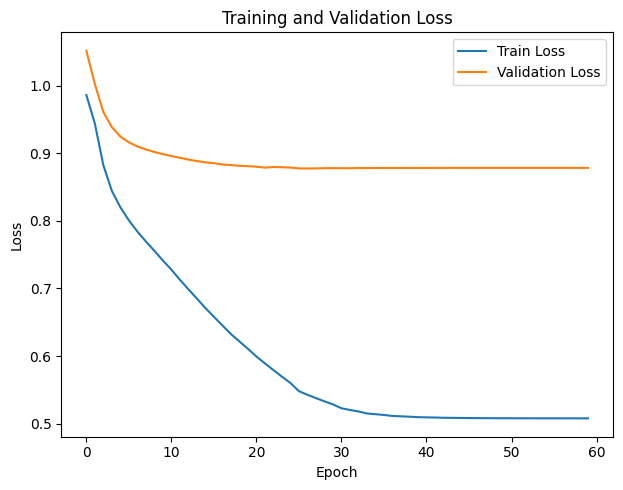

In [34]:
results = train(model, train_data, test_data, 
                MODEL_CONFIG['hyperparameters']['EPOCHS'], MODEL_CONFIG['hyperparameters']['REGULARIZATION'])

In [37]:
from hyperopt import hp
import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

In [33]:
train_data = CellDataset("processed_counts.csv", "labels.csv", mode='train')
test_data = CellDataset("processed_counts.csv", "labels.csv", mode='test')
train_data.counts.shape, test_data.counts.shape

(torch.Size([560, 765]), torch.Size([140, 765]))

In [49]:
def epoch_train(train_loader, model, loss_fn):
    total_epoch_train_loss = 0.0
    for counts, _, _ in train_loader:
        # counts = counts.to(device)

        logits = model(counts)
        loss = loss_fn(logits, counts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_train_loss += loss.item() * counts.size(0)

    # epoch_train_loss /= len(train_data)
    return total_epoch_train_loss

def epoch_test(test_loader, model, loss_fn):
    total_epoch_val_loss = 0.0
    
    with torch.no_grad():
        for counts, _, _ in test_loader:
            # counts = counts.to(device)

            logits = model(counts)
            loss = loss_fn(logits, counts)

            total_epoch_val_loss += loss.item() * counts.size(0)

    # epoch_val_loss /= len(test_data)
    return total_epoch_val_loss

In [44]:
train_data = CellDataset("processed_counts.csv", "labels.csv", mode='train')
test_data = CellDataset("processed_counts.csv", "labels.csv", mode='test')

In [81]:
def ray_train(config):
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)

    encoder = MLP(765, config['num_hidden_layers'], config['latent_dim'])
    decoder = MLP(config['latent_dim'], config['num_hidden_layers'], 765)
    # model = PBMCAutoEncoder(encoder, decoder).to(device)
    model = PBMCAutoEncoder(encoder, decoder)

    loss_fn = nn.MSELoss()
    w_decay = config['weight_decay'] * np.sqrt(config['batch_size']/ (len(train_data) * config['epochs'])) # from Loshchilov & Hutter, https://arxiv.org/abs/1711.05101
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=w_decay, fused=True)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], fused=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=config['lr_reduce_rate'], 
                                                           patience=config['patience'])

    for epoch in range(config['epochs']):
        model.train()
        epoch_train_loss = 0.0
        for counts, _, _ in train_loader:
            # counts = counts.to(device)
            logits = model(counts)
            loss = loss_fn(logits, counts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * counts.size(0)
        epoch_train_loss /= len(train_data)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for counts, _, _ in test_loader:
                # counts = counts.to(device)
                logits = model(counts)
                loss = loss_fn(logits, counts)
                epoch_val_loss += loss.item() * counts.size(0)
        epoch_val_loss /= len(test_data)

        scheduler.step(epoch_val_loss)
        tune.report({'val_loss': epoch_val_loss})
        

In [95]:
# hyperopt_space = {
#     'epochs': hp.choice('epochs', [50]),
#     'latent_dim': hp.choice('latent_dim', [16, 32, 64]),
#     'num_hidden_layers': hp.choice('num_hidden', [1, 2, 3, 4]),
#     'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
#     'batch_size': hp.choice('batch_size', [32, 64, 128]),
#     'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1e-3)),
#     'lr_reduce_rate': hp.loguniform('lr_reduce_rate', np.log(0.1), np.log(1)),
#     'patience': hp.choice('patience', [2,4,8])
# } 0.001
hyperopt_space = {
    'epochs': 50,
    'latent_dim': 64,
    'num_hidden_layers': 1,
    'batch_size': 64,
    'lr': hp.loguniform('lr', np.log(1e-3), np.log(1e-2)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.001), np.log(0.05)),
    'lr_reduce_rate': 0.5,
    'patience': 8
}

# Convert Hyperopt space to Tune format
tune_search = HyperOptSearch(
    hyperopt_space,
    metric="val_loss",
    mode="min",
)

# Early stopping scheduler
scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t=50,
    grace_period=10,
    reduction_factor=2
)

In [41]:
ray.get_gpu_ids()

[]

In [96]:
tuner = tune.Tuner(ray_train,
                   tune_config=tune.TuneConfig(
                       num_samples=50,
                       search_alg=tune_search,
                       scheduler=scheduler
                   ),
                  )
results = tuner.fit()

2025-04-21 15:11:30,365	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/ian/ray_results/ray_train_2025-04-21_15-10-22' in 0.0202s.
2025-04-21 15:11:30,371	INFO tune.py:1041 -- Total run time: 67.73 seconds (67.68 seconds for the tuning loop).


Text(0, 0.5, 'Loss')

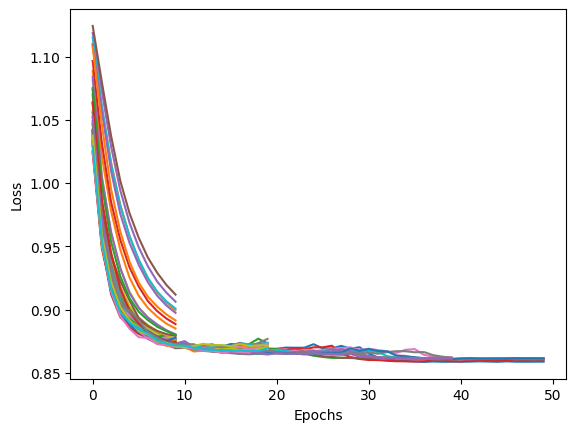

In [97]:
dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [98]:
best_config = results.get_best_result(metric="val_loss", mode="min")
print("Best hyperparameters:", best_config)

Best hyperparameters: Result(
  metrics={'val_loss': 0.8587975536073957},
  path='/Users/ian/ray_results/ray_train_2025-04-21_15-10-22/ray_train_06472c34_1_batch_size=64,epochs=50,latent_dim=64,lr=0.0068,lr_reduce_rate=0.5000,num_hidden_layers=1,patience=8,weight_d_2025-04-21_15-10-22',
  filesystem='local',
  checkpoint=None
)


In [341]:
def train2(config):
    torch.mps.empty_cache()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)

    encoder = MLP(765, config['num_hidden_layers'], config['latent_dim'])
    decoder = MLP(config['latent_dim'], config['num_hidden_layers'], 765)
    model = PBMCAutoEncoder(encoder, decoder).to(device)

    loss_fn = nn.MSELoss()
    w_decay = config['weight_decay'] * np.sqrt(config['batch_size']/ (len(train_data) * config['epochs'])) # from Loshchilov & Hutter, https://arxiv.org/abs/1711.05101
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=w_decay, fused=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=config['lr_reduce_rate'], 
                                                           patience=config['patience'])

    best_val_loss = float('inf')
    best_model = None
    history = {
        'train_loss': [],
        'val_loss': [],
    }

    epochs_pbar = trange(config['epochs'], desc='Epochs')
    for epoch in epochs_pbar:
        model.train()
        epoch_train_loss = 0.0
        for counts, _, _ in train_loader:
            counts = counts.to(device)
            logits = model(counts)
            loss = loss_fn(logits, counts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * counts.size(0)
        epoch_train_loss /= len(train_data)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for counts, _, _ in test_loader:
                counts = counts.to(device)
                logits = model(counts)
                loss = loss_fn(logits, counts)
                epoch_val_loss += loss.item() * counts.size(0)
        epoch_val_loss /= len(test_data)

        scheduler.step(epoch_val_loss)
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = deepcopy(model.state_dict())

    plot_history(history)
    model.load_state_dict(best_model)

    return {
        "model": model,
        "history": history,
        "best_val_loss": best_val_loss
    }

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

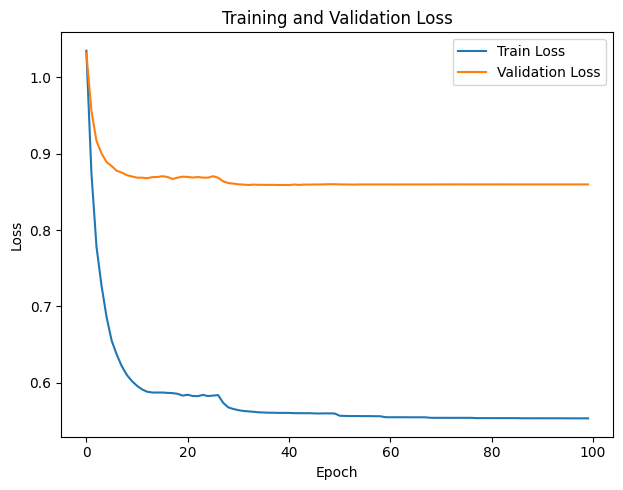

In [107]:
final_config = {
    'epochs': 100,
    'latent_dim': 64,
    'num_hidden_layers': 1,
    'batch_size': 64,
    'lr': 0.0062,
    'weight_decay': 0.04,
    'lr_reduce_rate': 0.5,
    'patience': 8
}
out = train2(final_config)

In [108]:
min(out['history']['val_loss'])

0.8588735733713423

In [116]:
torch.save(out['model'].state_dict(), "/Users/ian/1_Projects/hw/bioe145/final/models/final_model.pt")

In [339]:
out['model'].encoder.out_layer.weight

Parameter containing:
tensor([[-0.0002, -0.0208, -0.0687,  ...,  0.0175, -0.0109, -0.0444],
        [-0.0232, -0.0067, -0.0143,  ..., -0.0054, -0.0166,  0.0332],
        [-0.0043, -0.0222,  0.0171,  ..., -0.0092, -0.0395, -0.0220],
        ...,
        [-0.0173, -0.0177, -0.0127,  ...,  0.0058,  0.0080, -0.0089],
        [ 0.0309,  0.0373, -0.0383,  ..., -0.0086, -0.0108,  0.0171],
        [-0.0270,  0.0065, -0.0015,  ...,  0.0112,  0.0059, -0.0227]],
       device='mps:0', requires_grad=True)

### w/ weight decay

Text(0, 0.5, 'Loss')

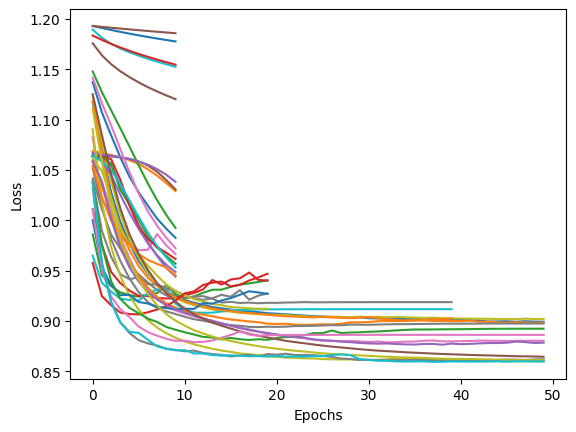

In [85]:
dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [86]:
best_config = results.get_best_result(metric="val_loss", mode="min")
print("Best hyperparameters:", best_config)

Best hyperparameters: Result(
  metrics={'val_loss': 0.859723060471671},
  path='/Users/ian/ray_results/ray_train_2025-04-21_14-40-57/ray_train_a500397d_40_batch_size=64,epochs=50,latent_dim=64,lr=0.0047,lr_reduce_rate=0.4391,num_hidden_layers=1,patience=8,weight__2025-04-21_14-41-50',
  filesystem='local',
  checkpoint=None
)


### W/ lr decay

Text(0, 0.5, 'Loss')

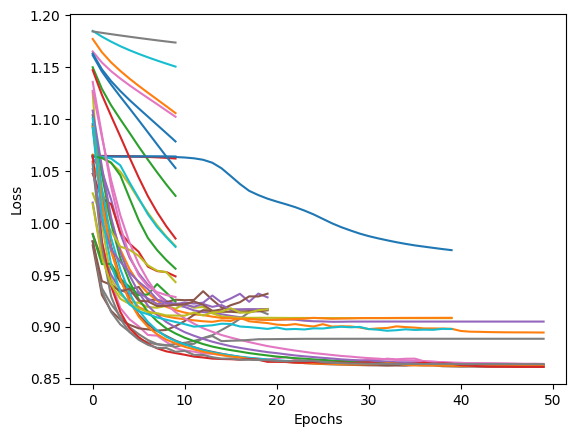

In [78]:
dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [79]:
best_config = results.get_best_result(metric="val_loss", mode="min")
print("Best hyperparameters:", best_config)

Best hyperparameters: Result(
  metrics={'val_loss': 0.86109756061009},
  path='/Users/ian/ray_results/ray_train_2025-04-21_14-29-15/ray_train_2b2f9d3f_26_batch_size=64,epochs=50,latent_dim=64,lr=0.0019,lr_reduce_rate=0.2120,num_hidden_layers=1,patience=4_2025-04-21_14-29-49',
  filesystem='local',
  checkpoint=None
)


### No lr decay

Text(0, 0.5, 'Loss')

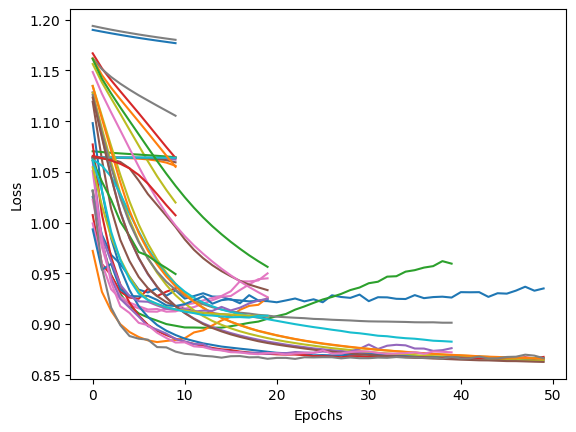

In [72]:
dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [74]:
best_config = results.get_best_result(metric="val_loss", mode="min")
print("Best hyperparameters:", best_config)

Best hyperparameters: Result(
  metrics={'val_loss': 0.8624543428421021},
  path='/Users/ian/ray_results/ray_train_2025-04-21_14-24-13/ray_train_788be673_36_batch_size=64,epochs=50,latent_dim=64,lr=0.0010,num_hidden_layers=1_2025-04-21_14-25-01',
  filesystem='local',
  checkpoint=None
)


In [14]:
from models import save_config, save_model

In [ ]:
save_config(MODEL_CONFIG, MODEL_CONFIG['saving']['RUN_NAME'])
save_model(results['model'], encoder, decoder, results['optimizer_state'], MODEL_CONFIG['saving']['RUN_NAME'])

Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

In [125]:
final_model = out['model']

In [144]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import seaborn as sns

In [140]:
labels_pd['bulk_labels']

0       CD14+ Monocyte
1            Dendritic
2             CD56+ NK
3      CD4+/CD25 T Reg
4            Dendritic
            ...       
695          Dendritic
696          Dendritic
697    CD4+/CD25 T Reg
698            CD19+ B
699          Dendritic
Name: bulk_labels, Length: 700, dtype: object

In [173]:
numpy_counts = counts_pd.iloc[:,1:].to_numpy().astype(np.float32)
numpy_counts

array([[-0.326, -0.191, -0.728, ..., -0.21 , -0.636,  4.011],
       [ 1.171, -0.191,  0.795, ..., -0.21 ,  2.63 , -0.49 ],
       [-0.326, -0.191,  0.483, ..., -0.21 ,  0.663, -0.49 ],
       ...,
       [-0.326, -0.191, -0.728, ..., -0.21 , -0.636,  1.226],
       [-0.326, -0.191, -0.728, ..., -0.21 , -0.636, -0.49 ],
       [-0.326, -0.191,  0.148, ..., -0.21 , -0.636, -0.49 ]],
      shape=(700, 765), dtype=float32)

In [186]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
umap = UMAP()
X_pca = pca.fit_transform(numpy_counts)
X_tsne = tsne.fit_transform(numpy_counts)
X_umap = umap.fit_transform(numpy_counts)

/Users/ian/1_Projects/hw/bioe145/final/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


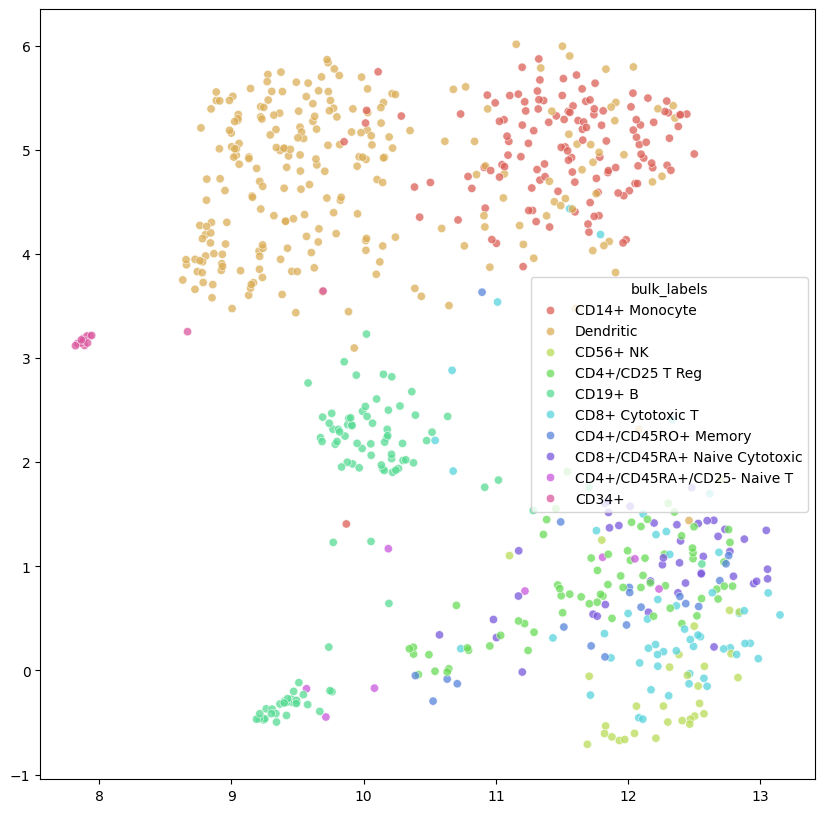

In [179]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_umap[:,0], y=X_umap[:,1],
    hue=labels_pd['bulk_labels'],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

### Latent Space Graphing

In [180]:
pca_encoder_model = MLP(765, 1, 64)
pca_encoder_model.load_state_dict(final_model.encoder.state_dict())
pca_encoder_model.eval()

MLP(
  (hidden_layers): Sequential()
  (out_layer): Linear(in_features=765, out_features=64, bias=True)
)

In [185]:
torch_counts = torch.from_numpy(numpy_counts)
logits = pca_encoder_model(torch_counts).detach().numpy()
pca_encoder = PCA(n_components=2)
tsne_encoder = TSNE(n_components=2)
umap_encoder = UMAP()

X_pca_encoder = pca_encoder.fit_transform(logits)
X_tsne_encoder = umap_encoder.fit_transform(logits)
X_umap_encoder = umap_encoder.fit_transform(logits)

/Users/ian/1_Projects/hw/bioe145/final/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ian/1_Projects/hw/bioe145/final/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.

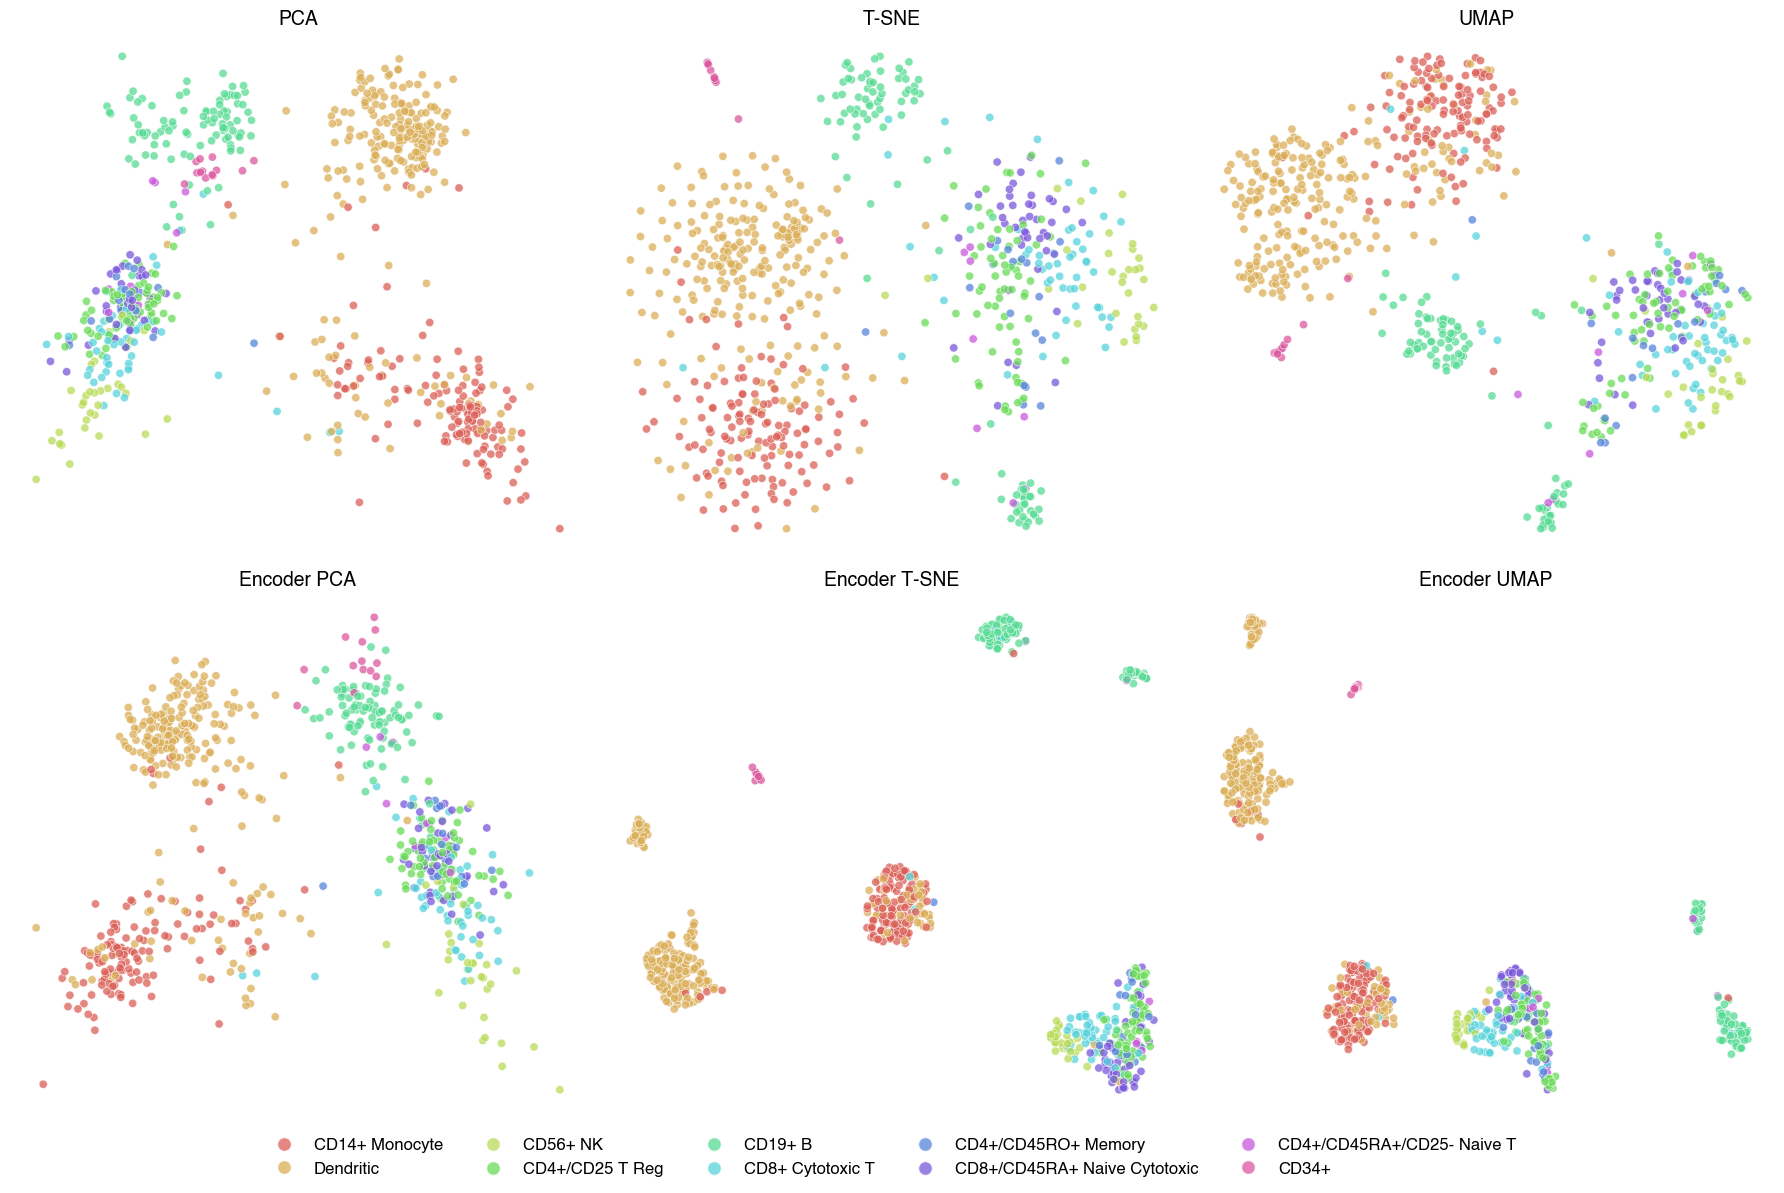

In [342]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axes = axs.flatten()
data_arrays = [X_pca, X_tsne, X_umap, X_pca_encoder, X_tsne_encoder, X_umap_encoder]
titles = ['PCA', 'T-SNE', 'UMAP', 'Encoder PCA', 'Encoder T-SNE', 'Encoder UMAP']

unique_labels = labels_pd['bulk_labels'].unique()
palette = dict(zip(unique_labels, sns.color_palette("hls", len(unique_labels))))

for i, (ax, data) in enumerate(zip(axes, data_arrays)):
    sns.scatterplot(
        x=data[:, 0], 
        y=data[:, 1],
        hue=labels_pd['bulk_labels'],
        palette=palette,
        alpha=0.75,
        legend=False,
        ax=ax
    )
    ax.set_title(titles[i])
    # ax.title.set_weight('bold')
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[label], 
                      markersize=10, alpha=0.75) for label in unique_labels]
fig.legend(handles, unique_labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0), frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make room for the legend
# plt.savefig("comparison_clean.svg", format="svg")
plt.show()